<h1 style="text-align: center;">
    ATSC 409 Project: 1D Radiative Model
</h1>
<h5 style="text-align: center;">
    Anirudh Duggal, Clinton Macadam, and Hanrui Duan
</h5>
<!-- # ATSC 409 Project: 1D Radiative Model
##### Anirudh Duggal, Clinton Macadam, and Hanrui Duan -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Runge-Kutta 4th order
def rk4(f, x0, y0, x1, n):
    h = (x1 - x0) / n
    x = np.arange(x0, x1, n)
    y = np.zeros((n + 1))
    y[0] = y0
    for i in range(n):
        k1 = h * f(x[i], y[i])
        k2 = h * f(x[i] + h / 2, y[i] + k1 / 2)
        k3 = h * f(x[i] + h / 2, y[i] + k2 / 2)
        k4 = h * f(x[i] + h, y[i] + k3)
        y[i + 1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return x, y

<h4 style="text-align: center;">
    Constants
</h4>

In [5]:
Ce = 2.08e-5  # J/m^2 * C
F = 3.80      # W/(m^2 * C)
A = 204       # W m^-2
B = 2.17      # W m^-2 C^-1


# Global Variables
num_lat_zones = 0
lats = 0
lats_frac = 0
insolation = 0
albedo = 0
temp = 0


In [7]:
# Adapted from geometric_setup.m
def geometry_setup():
    num_lat_zones = 10
    zonal_width = 90 / num_lat_zones

    # midpoint of each zone
    lats = np.array([0])
    lats = np.append(lats, np.arange(zonal_width / 2, 90 - zonal_width / 2, zonal_width))

    lats_rad = [lat * np.pi / 180 for lat in lats] 
    delta_rad = (np.pi / 2) / (num_lat_zones / 2)
    lats_frac = np.array([(np.sin(lats_rad + delta_rad) - np.sin(lats_rad - delta_rad)) for lats_rad in lats_rad], dtype=np.float64)
    
    # for _ in range(len(lats_rad)):
    #     lats_frac.append(np.sin(lats_rad + delta_rad) - np.sin(lats_rad - delta_rad))

    return num_lat_zones, lats, lats_frac

In [8]:
def insolation_setup(num_lat_zones, solar_constant = 1370, max_tilt = 23.5, days_in_year = 365, hours_in_day = 24, zonal_degrees = 360):
    total_solar = 0.0

    for hour in range(hours_in_day):
        noon_angle = zonal_degrees * hour / hours_in_day
        
        for longitude in range(zonal_degrees):
            sun_angle = longitude - noon_angle
            total_solar = total_solar + solar_constant * max(0.0, np.cos(np.pi / 180 * sun_angle))
    
    solar_constant = total_solar / (hours_in_day * zonal_degrees)

    insolation = np.zeros(num_lat_zones)

    for day in range(days_in_year):
        tilt = max_tilt * np.cos(2.0 * np.pi * day / days_in_year)

        for j in range(num_lat_zones):
            zenith = min(lats[j] + tilt, 90.0)
            insolation[j] += np.cos(zenith * np.pi/180)

    insolation = solar_constant * insolation / days_in_year
    return insolation

In [9]:
# Adapted from solve_temp.m

# adjustable parameters
F = 3.80                   # transport coefficient (in W/(m^2*degree C))
A = 204                    # radiative-heat-loss coefficient
B = 2.17                   # radiative-heat-loss coefficient
albedo_ice = 0.60          # albedo of ice
albedo_land = 0.30         # albedo of land
temp_critical = -10        # critical temperature (all ice)

step_num = 1                 # loop counter
max_temp_diff = 1.0E6       # using large value insures loop executes once
tol_temp_diff = 0.05         # max temp change before ending iteration
max_steps = 100              # max steps during iteration before stopping

In [27]:
def solveTemp(solar_mult, temp, num_lat_zones, lats_frac, albedo):
    # adjustable parameters
    F = 3.80                   # transport coefficient (in W/(m^2*degree C))
    A = 204                    # radiative-heat-loss coefficient
    B = 2.17                   # radiative-heat-loss coefficient
    albedo_ice = 0.60          # albedo of ice
    albedo_land = 0.30         # albedo of land
    temp_critical = -10        # critical temperature (all ice)

    step_num = 1                 # loop counter
    max_temp_diff = 1.0E6        # using large value insures loop executes once
    tol_temp_diff = 0.05         # max temp change before ending iteration
    max_steps = 1000             # max steps during iteration before stopping

    while max_temp_diff > tol_temp_diff and step_num < max_steps:
        temp_old = temp
        step_num += 1

        # albedo is either land albedo (T > temp_critical) or ice (T < temp_critical)

        for j in range(num_lat_zones):
            if temp_old[j] > temp_critical:
                albedo[j] = albedo_land
            else:
                albedo[j] = albedo_ice

        temp_avg = sum(lats_frac * temp)
        temp = (solar_mult * insolation * (1 - albedo) + F * temp_avg - A) / (B + F)
        max_temp_diff = max(abs(temp - temp_old))

    if step_num >= max_steps:
        raise Exception('Too many iterations - Try different parameters')

    return temp_avg


C:\Users\anisw\AppData\Local\Temp\ipykernel_39032\2022059777.py:28: RuntimeWarning: overflow encountered in double_scalars
  temp = (solar_mult * insolation * (1 - albedo) + F * temp_avg - A) / (B + F)
C:\Users\anisw\AppData\Local\Temp\ipykernel_39032\2022059777.py:29: RuntimeWarning: invalid value encountered in subtract
  max_temp_diff = max(abs(temp - temp_old))


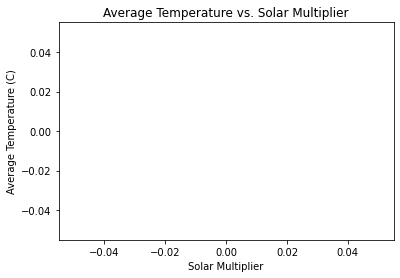

In [29]:
# Adapted from one_dim_ebm.m
num_lat_zones, lats, lats_frac = geometry_setup()
insolation = insolation_setup(num_lat_zones)

albedo = temp = np.zeros(num_lat_zones)

for j in range(num_lat_zones):
    temp[j] = -60.0


solar_mult = np.zeros(80)
avg_temp = np.zeros(80)

for k in range(60, 140):
    solar_mult[k - 60] = k / 100.0
    avg_temp[k - 60] = solveTemp(solar_mult[k - 60], temp, num_lat_zones, lats_frac, albedo)

plt.plot(solar_mult, avg_temp, 'b')
plt.title('Average Temperature vs. Solar Multiplier')
plt.xlabel('Solar Multiplier')
plt.ylabel('Average Temperature (C)')
plt.show()

In [11]:
def rk4Ode(x, y):
    avgTemp = np.average(temp)
    PGain = [S * (1 - a) for S, a in zip(insolation, albedo)]
    PLoss = [A + B * t + F * (t * avgTemp) for t in temp]
    return (PGain - PLoss) / Ce

In [14]:
rk4(rk4Ode, 2020, 14, 2038, 1)

TypeError: rk4Ode() takes 0 positional arguments but 2 were given